*Francisco Pereira [camara@dtu.dk], DTU Management*

# Advanced Business Analytics

## Lecture 9 - Causality - Part 2: Ice Cream Sales

...so let's now try to solve our Ice Cream sales problem from the perspective of Structure Causal Models. 

From a conversation with the Scuba operators and the Ice Cream sales company, you concluded that people do go diving regardless of the temperature (you can always have a thick wet suit!), while people from the ice cream shops (and the hotels) say that with high temperature there's clearly more clients. So you designed the following causal graph:

<img src="http://mlsm.man.dtu.dk/scm.png" alt="Drawing" style="width: 600px;"/>

Having this, you can now estimate your Structural Causal Model with the data available. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score




In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset=pd.read_csv("ice_cream_sales.csv")

We created an SCM dictionary for you, and the code to learn it. 

In [4]:
scm={}

In [5]:
#Creates an assignment function for a cause-effect relationship in the SCM
#
def generate_ML_assignment(trainset, testset, x_features, y_feature, model):
    model.fit(trainset[x_features], trainset[y_feature])
    score=model.score(testset[x_features], testset[y_feature])
    
    print("training performance:", model.score(trainset[x_features], trainset[y_feature]))
    print("testset performance:",  score)
    print("-"*20+"\n")
              
    
    return model
    

We're doing the very same train/test data split as before, so that we can make a comparison!

In [6]:
train, test=train_test_split(dataset, shuffle=False)

We saw that the Gradient Boosting model was the best before, so let's use it in the SCM for now (note that you could use different models for each cause-effect relationship!)

In [7]:
SCM_ML_MODEL=GradientBoostingRegressor


Now, let's follow the graph above. We can see that "Tourists" is only dependent on temperature

In [8]:
causes=['Temperature']
effects=['Tourists']
scm['Tourists']={'model':generate_ML_assignment(train, test, causes, effects, SCM_ML_MODEL()), 'causes': causes, 'effects':effects}

training performance: 0.9838428401924272
testset performance: 0.974082313973503
--------------------



Do you want to make the models for Ice Cream and for Scuba?

In [9]:
causes=['Temperature', 'Tourists']
effects=['Ice_Cream']
scm['Ice_Cream']={'model':generate_ML_assignment(train, test, causes, effects, SCM_ML_MODEL()), 'causes':causes, 'effects':effects}

training performance: 0.9978024714375499
testset performance: 0.9943361479611919
--------------------



In [10]:
causes=[ 'Tourists']
effects=['Scuba']
scm['Scuba']={'model':generate_ML_assignment(train, test, causes, effects, SCM_ML_MODEL()), 'causes':causes, 'effects':effects}

training performance: 0.9589685112810257
testset performance: 0.9433893696045019
--------------------



Take a look at the scm that you created:

In [11]:
scm

{'Tourists': {'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0, warm_start=False),
  'causes': ['Temperature'],
  'effects': ['Tourists']},
 'Ice_Cream': {'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                     

-------------

Now it's time to create the forward inference for the full SCM. This is a function that, given a dataset, will propagate across the graph (from "causes" to "effects") to predict all possible nodes. We will make the code for you. 

First, we have a code that verifies, for a certain SCM assignment function, if we already have the data (the "causes" for that SCM assignment function) to run that function, and thus generate the "effects"

In [12]:
#Extract the data for applying a cause-effect function
#Sometimes we don't have access to all the data, but are "allowed" to marginalize the missing data
#This marginalization in this case is trivially done by averaging in the dataset (e.g. imagine we had instead a marginal distribution)

def get_sufficient_causes_df(sufficient_causes, causes_df, dataset):
    causes=causes_df.columns
    unsatisfied=[cause for cause in sufficient_causes if cause not in causes]
    #print(len(unsatisfied))
    if len(unsatisfied)==0:   #all the data is available, just send it back, it is ready to calculate effects!
        return causes_df[sufficient_causes]
    
                  #if not all data is available,
    return None   #we cannot execute this cause-effect function
    
    
        
        

This is where we do the actual inference. 

**note: this code is recursive, maybe you never saw this before. A recursive function is one where it calls itself. ;-) It is very helpful to traverse a graph. Try to understand how it works.**

In [13]:
#The general idea of this function is to always propagate from causes to effects. So, whenever you have the data that 
#you can apply to a certain SCM assignment(i.e. a function Effects=f(Causes)), it just makes the prediction of that
#"effect", and adds it to the existing "causes" list. Then, it proceeds to the next SCM assignments

def forward_inference(SCM, causes_df, effects, dataset=None):
    applied_causes=[]
    causes=causes_df.columns
    new_causes_df=causes_df.copy()
    new_SCM={}
    for ce_function in SCM.keys():    #for each SCM assginment function
        sufficient_causes=SCM[ce_function]['causes']    #get it's "causes"
        if set(SCM[ce_function]['effects']).issubset(causes):   #and its effects
            #If we have already infered the effect before (either because it is already known or it is an intervention),
            #we need to ignore it
            continue
       
        #check if the current dataset has the causes for this SCM assignment
        sufficient_causes_df=get_sufficient_causes_df(sufficient_causes, new_causes_df, dataset)
        if not isinstance(sufficient_causes_df, pd.DataFrame):  #if not (i.e. the "get_sufficient_causes_df" returned None),
            new_SCM[ce_function]=SCM[ce_function]               #we need to keep this SCM assignment in our dictionary, 
            continue                                            #so that we can apply it later

        #otherwise, we're ready to propagate from causes to effects
        applied_causes+=sufficient_causes
        new_causes=SCM[ce_function]['effects']
        new_causes_df[new_causes[0]]=SCM[ce_function]['model'].predict(sufficient_causes_df) #untested for multiple effects (i.e. the "effects" model that we learn each time only has one output variable)

        satisfied_effects=[effect for effect in new_causes_df.columns if effect in effects]
        if satisfied_effects==effects:
            #we have satisfied the required effects (the original target variable, in our example it is "Ice Cream")
            #so we can just return the DF, which has everything we need!
            return new_causes_df[satisfied_effects]

    #calling recursion (applying the same thing until our target effect is calculated)
    return forward_inference(new_SCM, new_causes_df, effects, dataset)
        
    
        
        
        

---------------

## Testing with original dataset

Let's now run the original test set, so that we can compare with the other models we created before

In [14]:
x_features=['Tourists', 'Temperature', 'Scuba']

Let's start with the "Tourists" model first:

In [15]:
tourist_predictions=forward_inference(scm, test[x_features], ['Tourists'])

In [16]:
r2_score(test['Tourists'], tourist_predictions)

1.0

In [17]:
mean_absolute_error(test['Tourists'], tourist_predictions)

0.0

Do you want to try now with the "Ice_Cream" variable?

In [18]:
ice_cream_predictions=forward_inference(scm, test[x_features], ['Ice_Cream'])

In [19]:
r2_score(test['Ice_Cream'], ice_cream_predictions)

0.9943361479611919

In [20]:
mean_absolute_error(test['Ice_Cream'], ice_cream_predictions)

85.60562165279865

----------------

### Testing in new distribution

Now it's the big moment... let's try with the low season test dataset!

In [21]:
lowseasondataset=pd.read_csv("lowseason_campaign.csv")

In [22]:
Ice_Cream_new_dist_prediction=forward_inference(scm, lowseasondataset[x_features], ['Ice_Cream'])

In [23]:
r2_score(lowseasondataset['Ice_Cream'], Ice_Cream_new_dist_prediction)

0.3575997649377337

In [24]:
mean_absolute_error(lowseasondataset['Ice_Cream'], Ice_Cream_new_dist_prediction)

205.21112067309312

Text(0, 0.5, 'Predicted')

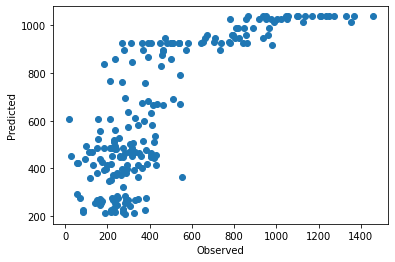

In [25]:
plt.scatter(lowseasondataset['Ice_Cream'], Ice_Cream_new_dist_prediction)
plt.xlabel("Observed")
plt.ylabel("Predicted")



Interesting, no? You can make much better predictions when you correctly follow the causal graph! In practice, what you did was an "intervention" in the "Tourists" variable, which affected both the "Scuba" and the "Ice Cream" variables. For the latter, the effect is lower than before (do you want to check?) because in cold weather people don't buy as many ice creams...